In [1]:
%config InlineBackend.figure_formats = ['svg']
from collections import deque
import datetime
import numpy as np
import matplotlib.pyplot as plt; plt.style.use('ggplot')
import matplotlib.dates as mdates

# Subdaily block schedules

Our previous analysis has focused on daily testing schedules. However, to avoid crowding at popular times of day, we need to consider how we might load-balance schedules across various subdaily time intervals. The following schemes have been proposed:
* **Loose**: allow people to decide whether they would like to tested in the morning, afternoon, or evening (approximate time windows might be 7AM-12PM, 12PM-5PM, 5PM-9PM).
* **2 hour-4 hour blocks**: This is even more fine-grained than above. It is believed that short windows allow for more control of load balancing, at the expensive of increased inconvenience (and therefore higher no-show/lateness rates).

Rather than just computing load-balance numbers, we should consider using some basic queueing theory to compute *maximum wait time* (in minutes) under reasonable assumptions for a given choice of granularity—though lab-side load balancing is relevant at the daily level, wait time is the more operationally relevant statistic on campus.

Even shorter blocks will be prone to bursts. For instance, personal experience suggests that campus services are heavily utilized immediately after class periods. Even though we believe that previous semesters' course catalogues are not likely to be representative of the fall 2020 course schedule, we might try using the Tufts block system (with popularity weights assigned to the blocks) as a basis for this analysis.

Students, staff, and faculty may have different spike times—non-teaching staff is probably aligned to the standard 9-5 workday with a lunch break, students are oriented around the class block schedule (for much of the day), and the behavior of faculty is probably a mix of these patterns.

### Questions
* Does it make sense to integrate wait times into the app? (This [notable paper](https://www.jstor.org/stable/pdf/1427345.pdf) discusses aware vs. uwaware customers.)
* Are test times really deterministic, or might some take significantly longer than others?
* Are there any good internal data sources to help us think about activity bursts? Good proxies might include
  * Dormitory ID swipes
  * Meal swipes (clearly biased toward meal periods)
  * Library usage (printing activity, book/media reservation activity

In [2]:
# 8AM - 8PM is reasonable here (approximately matching usual dining hours)
t_start = datetime.datetime(year=2020, month=9, day=1, hour=8)
hours_per_day = 12 

# 0th-order estimates for Tufts.
cohorts_daily = {
    'on-campus students': 2500,
    'off-campus students': 2500,
    'staff': 1000,
    'faculty': 1000
}
test_length_min = 5
n_test_stations = 7 # TODO: consider multiple testing centers.

In [3]:
max_tests_per_day = (n_test_stations * hours_per_day * 60) / test_length_min
print('Max tests per day:', max_tests_per_day)

Max tests per day: 1008.0


In [4]:
demand_per_day = (2 / 7) * sum(cohorts_daily.values())
print('Demand per day:', demand_per_day)

Demand per day: 2000.0


### Cases
* Perfectly uniform distribution, long day (12-14hr)
* Uniform distribution in concentrated window (2-4hr)
* Long day with spikes
  * Meal periods
  * Class periods
  * Workday start/end
  
### Formulation
There are a few options here. Load balancing and wait times are correlated (*prima facie*, better load balancing will tend to lead to shorter wait times), so we could go with a homogenous formulation with load balancing as the metric for evaluating both day-to-day performance and hourly performance. This is a natural extension of the models we already have.

However, it is not immediately obvious that using coarse windows (e.g. windows of 4–5 hours) will offer any significant improvement over per-day scheduling.

### Experiments
Choose a reasonable set of unbalanced load scenarios and compare maximum waiting times under reasonable assumptions to a balanced load model.

In [5]:
resolution_min = 1
t_delta = datetime.timedelta(minutes=resolution_min)
n_steps = int((hours_per_day * 60) / resolution_min)

In [6]:
def queue_mc(step_lambdas, n_servers, test_length, n_runs=5000):
    n_steps = len(step_lambdas)
    wait_times_at_step = [[] for _ in range(n_steps)]
    for run_idx in range(n_runs):
        demand_per_step = np.random.poisson(step_lambdas)
        # Test demand is served on a FIFO basis.
        q = deque()
        for step, demand in enumerate(demand_per_step):
            for _ in range(demand):
                q.append(step)
        server_states = np.zeros(n_servers)
        for step in range(n_steps):
            # Fill as many slots as possible.
            for server_idx, t_done in enumerate(server_states):
                if t_done <= step and q and q[0] <= step:
                    next_t = q.popleft()
                    wait_times_at_step[next_t].append(step - next_t)
                    server_states[server_idx] = next_t + test_length
    mean_wait_times = [np.mean(s) for s in wait_times_at_step]
    wait_times_p5 = [np.percentile(s, 1) for s in wait_times_at_step]
    wait_times_p95 = [np.percentile(s, 99) for s in wait_times_at_step]
    return mean_wait_times, wait_times_p5, wait_times_p95

In [7]:
uniform_expected_demand = demand_per_day / (hours_per_day * 60)
uniform_step_lambdas = uniform_expected_demand * np.ones(n_steps)
mean_uniform, p1_uniform, p99_uniform = queue_mc(uniform_step_lambdas, n_test_stations, test_length_min)

In [8]:
meal_heavy_step_lambdas = uniform_expected_demand * np.ones(n_steps)
meal_heavy_step_lambdas[30:90] *= 5 # 8:30AM-9:30AM post-breakfast
meal_heavy_step_lambdas[240:300] *= 5 # 12:00PM-1:00PM post-lunch
meal_heavy_step_lambdas[570:630] *= 5 # 5:30PM-6:30PM post-dinner
meal_heavy_step_lambdas *= (demand_per_day / meal_heavy_step_lambdas.sum())  # normalize expectation to daily demand
mean_meal_heavy, p1_meal_heavy, p99_meal_heavy = queue_mc(meal_heavy_step_lambdas, n_test_stations, test_length_min)

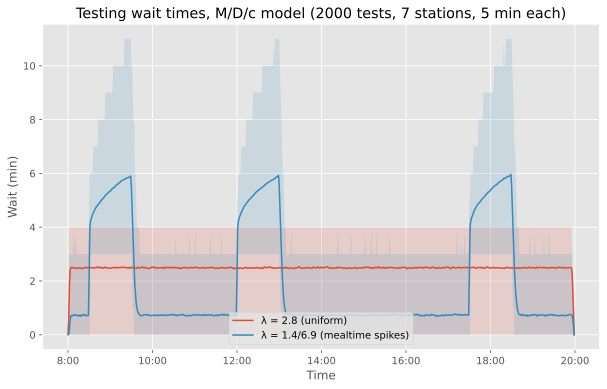

In [9]:
fig, ax = plt.subplots(figsize=(10, 6))
t = [t_start + i * t_delta for i in range(n_steps)]
ax.plot(t, mean_uniform,
        label='λ = {:.1f} (uniform)'.format(uniform_expected_demand))
ax.fill_between(t, p1_uniform, p99_uniform, alpha=0.15)
ax.plot(t, mean_meal_heavy,
        label='λ = {:.1f}/{:.1f} (mealtime spikes)'.format(meal_heavy_step_lambdas.min(),
                                                           meal_heavy_step_lambdas.max()))
ax.fill_between(t, p1_meal_heavy, p99_meal_heavy, alpha=0.15)
ax.set_title(f'Testing wait times, M/D/c model ({int(demand_per_day)} tests, {n_test_stations} stations, {test_length_min} min each)')
ax.set_xlabel('Time')
ax.set_ylabel('Wait (min)')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%-H:%M'))
plt.legend(loc='lower center')
plt.savefig('mdc_initial.png', dpi=300, bbox_inches='tight')
plt.show()